In [2]:
import torch
import torch.nn.functional as Func
import pandas as pd
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import trange

%matplotlib inline

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simple Regression Model

In [3]:
class SimpleModel(torch.nn.Module):
    def __init__(self, p, decay):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(1,20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            #torch.nn.Tanh(),
            torch.nn.Dropout(p=self.dropout_p),
            torch.nn.Linear(20,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X).view(-1,1), requires_grad=False)
        return self.f(X)

In [5]:
def uncertainity_estimate(x, model, iters, l2):
    outputs = np.hstack([model(x).data.numpy() for i in trange(iters)])
    y_mean = outputs.mean(axis=1)
    y_variance = outputs.var(axis=1)
    tau = l2 * (1. - model.dropout_p) / (2. * N * model.decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std

## Generating input signal

In [8]:
N = 200 ##  number of points
min_value = -10
max_value = 10

x_test = np.linspace(min_value - 10, max_value + 10, N)
noise = np.random.normal(loc = 10, scale = 80, size = N)
x_obs = np.linspace(min_value, max_value, N)
y_obs =  x_obs**3 + noise

# Normalise data:
x_mean, x_std = x_obs.mean(), x_obs.std()
y_mean, y_std = y_obs.mean(), y_obs.std()
x_obs = (x_obs - x_mean) / x_std
y_obs = (y_obs - y_mean) / y_std
x_test = (x_test - x_mean) / x_std

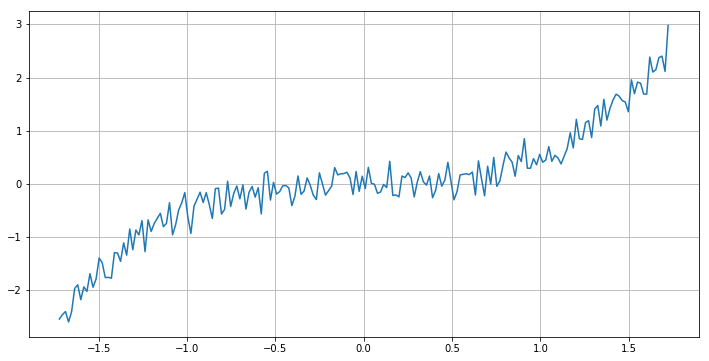

In [9]:
plt.figure(figsize=(12,6))
plt.plot(x_obs, y_obs)
plt.grid()

In [20]:
model = SimpleModel(p=0.5, decay=1e-6)
criterion  = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0., weight_decay=model.decay)
#clipping = 0.25

In [22]:
for iter in range(20000):
    y_pred = model(x_obs)
    y_true = Variable(torch.Tensor(y_obs).view(-1,1), requires_grad=False)
    optimizer.zero_grad()
    loss = criterion(y_pred, y_true)
    loss.backward()
    optimizer.step()
    #torch.nn.utils.clip_grad_norm(model.parameters(), clipping)
    
    if iter % 2000 == 0:
        print("Iter: {}, Loss: {}".format(iter, loss.data.numpy()))

Iter: 0, Loss: 0.22405308485031128
Iter: 2000, Loss: 0.229155495762825
Iter: 4000, Loss: 0.1771717667579651
Iter: 6000, Loss: 0.28067100048065186
Iter: 8000, Loss: 0.20927198231220245
Iter: 10000, Loss: 0.17815925180912018
Iter: 12000, Loss: 0.1798977106809616
Iter: 14000, Loss: 0.2554773688316345
Iter: 16000, Loss: 0.20449665188789368
Iter: 18000, Loss: 0.21615302562713623


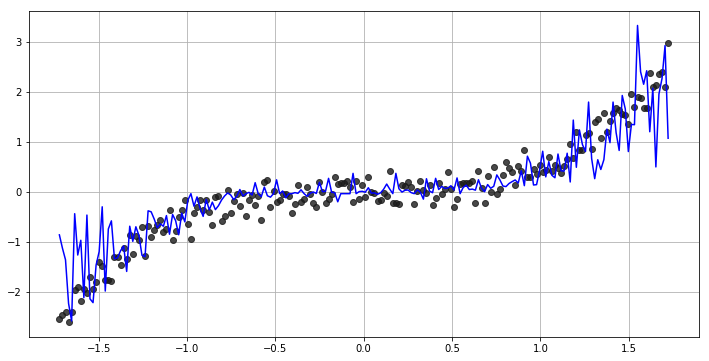

In [23]:
plt.figure(figsize=(12,6))
y_pred = model(x_obs)
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_obs, y_pred.data.numpy(), ls="-", color="b", label="mean")
plt.grid()

## Getting Uncertainties

100%|██████████| 200/200 [00:00<00:00, 2188.17it/s]


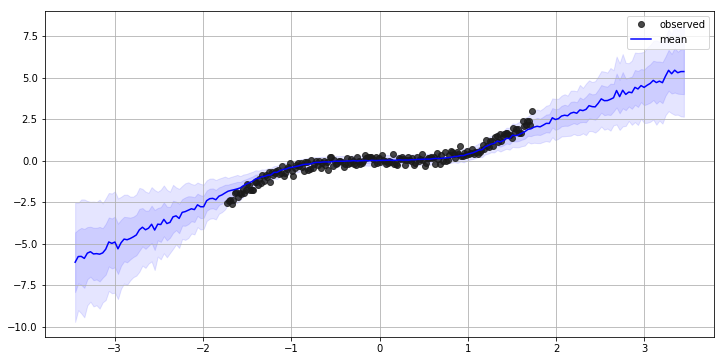

In [24]:
iters_uncertainty = 200

## Lengh-Scale - a priori with long length-scale l results in weights with low magnitude, 
## and as a result slow-varying induced functions. 
## On the other hand, placing a prior distribution with a short length-scale gives 
## high magnitude weights, and as a result erratic functions with high frequencies.
lengthscale = 0.01
n_std = 2 # number of standard deviations to plot
y_mean, y_std = uncertainity_estimate(x_test, model, iters_uncertainty, lengthscale)

plt.figure(figsize=(12,6))
plt.plot(x_obs, y_obs, ls="none", marker="o", color="0.1", alpha=0.8, label="observed")
plt.plot(x_test, y_mean, ls="-", color="b", label="mean")
for i in range(n_std):
    plt.fill_between( x_test,
        y_mean - y_std * ((i+1.)/2.),
        y_mean + y_std * ((i+1.)/2.),
        color="b",
        alpha=0.1)
plt.legend()
plt.grid()